# Overview
<b>Objective:</b> This notebook introduces fundamental concepts of time series analysis and modeling using SARIMA. <br>

<b>Structure of notebook:</b>
- 1. Import libraries
- 2. Import data
- 3. Exploratory Data Analysis
- 4. Time series data pre-processing:
    - Smoothing of time series
    - Decomposition of time series
- 5. Time series analysis: identification of underlying processes
    - Autocorrelation
    - Partial autocorrelation
    - Recognising time series processes using ACF and PACF:
        - Noise
        - Autoregression (AR)
        - Moving average (MA)
    - Stationarity
        - Definition & visualisation
        - Statistical testing
- 6. Introduction to modeling using SARIMA
    - Basic concepts and parameters
    - Model selection and parameter tuning:
        - Initial estimates of parameters using ACF and PACF
        - Residuals diagnostics
        - Gridsearch for selected parameter space 
    - Best model's result visualisation & prediction

## 1. Import libraries

In [149]:
# Utility packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import itertools
from io import BytesIO

# Import statsmodels packages
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX

## 2. Import data
- Minimum daily temperatures over 10 years (1981-1990) in Melbourne, Australia
- Unit in degress Celcius
- Source of the data is credited as the Australian Bureau of Meteorology

In [36]:
df = pd.read_csv("temp.csv")

In [37]:
df.head()

,date,temp
0,01/01/1981,20.7
1,02/01/1981,17.9
2,03/01/1981,18.8
3,04/01/1981,14.6
4,05/01/1981,15.8


### 3. EDA

In [38]:
df.isna().sum()

date    0
temp    0
dtype: int64

In [39]:
df.describe()

,temp
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3650 non-null   object 
 1   temp    3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB


In [41]:
df.head()

,date,temp
0,01/01/1981,20.7
1,02/01/1981,17.9
2,03/01/1981,18.8
3,04/01/1981,14.6
4,05/01/1981,15.8


In [42]:
# Need to change the date column into datetime format for further analysis
df["date"] = pd.to_datetime(df['date'], format='%d/%m/%Y') # format must match
# Turn datetime into index
df = df.set_index("date")

In [43]:
# Check whether similar number of data points available for each year
np.unique(df.index.year,return_counts=True)

(array([1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990],
       dtype=int64),
 array([365, 365, 365, 365, 365, 365, 365, 365, 365, 365], dtype=int64))

In [44]:
# Take a look at data for a particular year
df["1990":"1990"]

,temp
date,
1990-01-01,14.8
1990-01-02,13.3
1990-01-03,15.6
1990-01-04,14.5
1990-01-05,14.3
...,...
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5


<AxesSubplot:xlabel='date', ylabel='temp'>

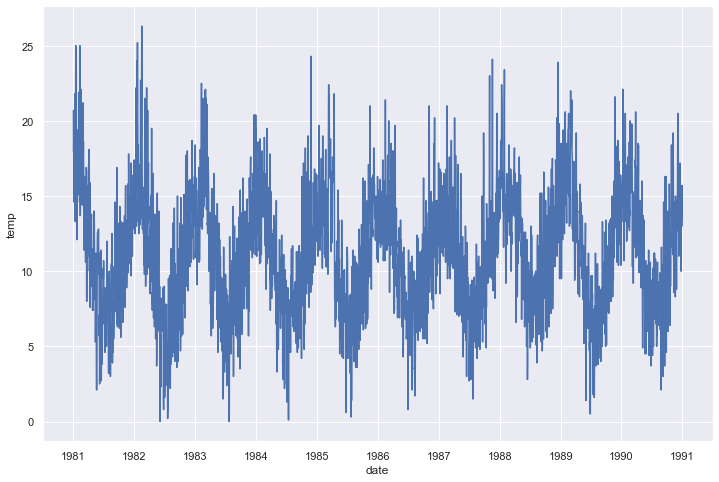

In [46]:
sns.set_theme(style="darkgrid")
sns.lineplot(x=df.index,y="temp",data=df)

## 4. Data Preprocessing
### Smoothing of time series: 
#####  Moving average:
- Calculing the moving average for a given time window of t values. Using this method, the fluctuations will be smoothened out as changes from day to day is averaged out over the time window.
- The original frequency of the dataset is retained, the daily granuality remains.
- Note that smoothing using moving average does introduce NaN at the beginning and the end of the newly created series
- The average value of the series can be calculated at the beginning, end or centre of the window.

##### Resampling: 
- The data will be divided into bins of n days and an aggregate function such as sum(), mean(), etc can be performed.
- Here the original frequency of the dataset is changed (have less timestamps)
- This is helpful in the case where the data is more granular than needed
- No NA is produced by this process.
- Resampling only works for datetime index

In [47]:
# Moving average
month = df.temp.rolling(window=30,center=True).mean()
month.shape

(3650,)

In [48]:
month_rs = df.temp.resample("M").mean()  # "W-Mon" e.g or by quarter
month_rs.shape

(120,)

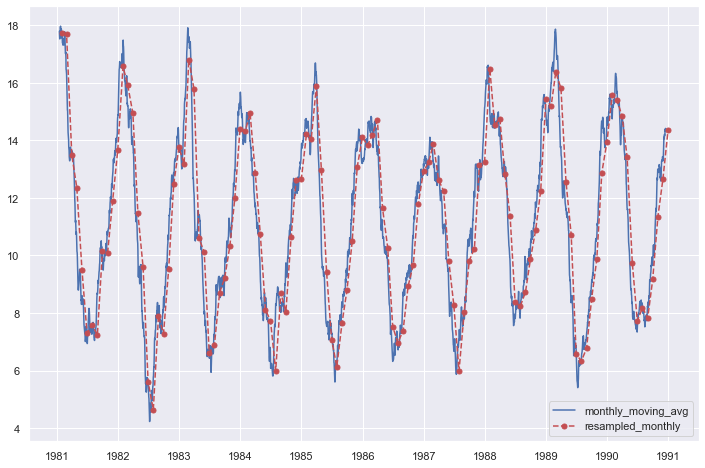

In [49]:
plt.plot(month.index,month,label="monthly_moving_avg")
plt.plot(month_rs.index,month_rs,color="r",linestyle="--",marker="o",ms=5,label="resampled_monthly")
plt.legend()
plt.show()

### Decomposition of time series: 
- Time series data can be decomposed into 3 separate components: trend, seasonality and noise (residuals).
- Trend and seasonality make up the systematic part of time series data and can be modelled while noise can't.
- Trend refers to the overall parametric tendency of the data, e.g., increasing or decreasing with a linear or exponential relationship with time.
- Seasonality refers to repeated patterns existing in the series. The repetition frequency is related to seasonaly natural or human behaviours such as weekly, monthly, yearly, etc.
- A time series might or might not have trend and/or seasonality
- There are 2 types of decomposition:
    - Additive: target = trend + seasonability + residuals
    - Multiplicative: target = trend x seasonability x residuals
    - By inspecting the residuals, often the correct choice of decomposition can be made. The residual is expected to fluctuate around 0 if the right choice is selected. An additive model is appropriate if the variance is constant with time
- Other features of a time series are shocks and cycles:
    - Shocks (irregularities): one-off event 
    - Cycles are repeated events with up and down patterns that are not seasonal and could have varying length. Cycles are harder to detect 

In [50]:
# Resampled into weekly cadence
week_rs = df.resample('W').mean() # "W-Mon" e.g or by quarter
week_rs.head()

,temp
date,
1981-01-04,18.000000
1981-01-11,17.542857
1981-01-18,20.371429
1981-01-25,15.771429
1981-02-01,16.657143


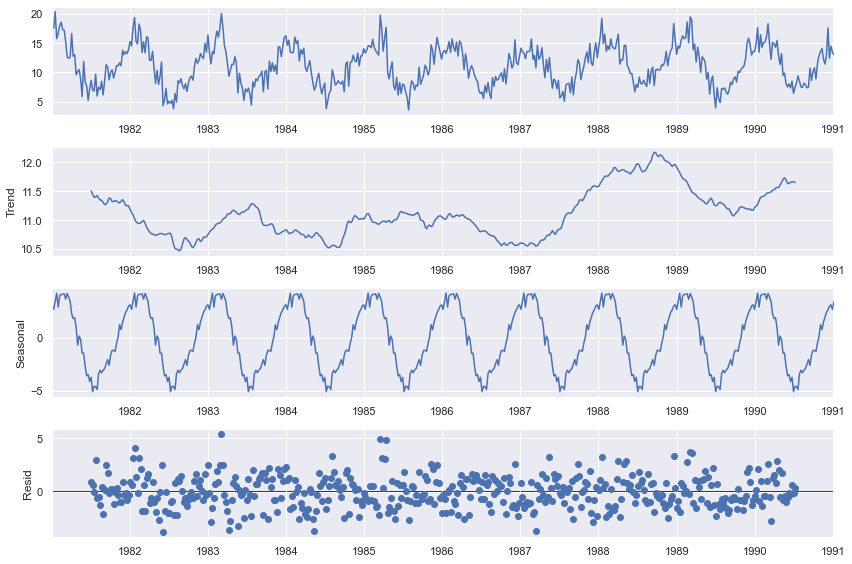

In [51]:
plt.rcParams['figure.figsize'] = 12, 8
decom = seasonal_decompose(week_rs,model="additive") # Require the index of DF to have a frequency
decom.plot()
plt.show()

## 5. Time series analysis: identification of underlying processes
### Autocorrelation:
- Measures the correlation of the time series with itself in order to determine how the present values are correlated with the past values
- Autocorrelation measurements has its own coefficient, similar to pearson product-moment coefficient. Each "lag" or "shift" - how many steps you look back into the time series - is associated with an autocorrelation measurement from -1 to 1 where +1 implies a perfect positive correlation and -1 represents a perfect negative correlation or anticorrelation.
- In essence, autocorrelation is trying to measure the pearson coefficient (linearity relationship) between a time series and its shifted copy. For the $k^{th}$ lag, the autocorrelation coefficient is:
\begin{align}
\rho_{k}\,\,\,\, &=& \frac{\sum\limits_{i=1}^{N-k}\left(x_{i}-\bar{x}\right)
\left(x_{i+k}-\bar{x}\right)}{\sum\limits_{i=1}^{N}\left(x_{i}-\bar{x}\right)^2}
\\
\\
&=& \frac{\sum\limits_{i=1}^{N-k}\left(x_{i}-\bar{x}\right)
\left(x_{i+k}-\bar{x}\right)}{\sigma^2}
\end{align}

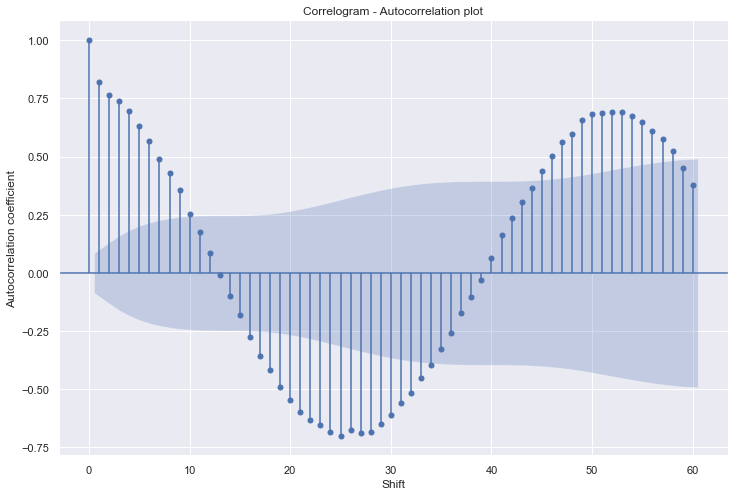

In [52]:
ax = plot_acf(week_rs,alpha=0.05,lags=60)

plt.rcParams.update({'font.size': 30})
plt.xlabel("Shift")
plt.ylabel("Autocorrelation coefficient")
plt.title("Correlogram - Autocorrelation plot")

plt.show()

Understanding autocorrelation plot:
- The  $0^{𝑡ℎ}$  lag will always have an autocorrelation of 1 (a value is perfectly correlated with itself)
- The blue shaded area is the confidence interval. Any autocorrelations within this area are usually labelled as not statistically significant.
- The alpha parameter set the confidence level threshold, alpha = 0.05 means 95% condifence
- If the time series is periodic or exhibits seasonality, the correlogram should also be periodic with the same wavelength / perid. This periodicity is often not easily seen by just plotting the raw data but shows up in correlogram.

Here, temperature at any given week correlates well with the past couple of weeks then falls off as we further go back in time. However, this starts increasing again around lag 15 but with a negative correlation.

Autocorrelation plot confirms the initial observation of seasonality effect with a period of 1 year = 52 weeks.

### Partial autocorrelation

- The autocorrelations for autocorrelation coefficient remained significant for several lags after the first. This is because - if $y_{t+1}$ is correlated with $y_{t}$ and $y_{t}$ is correlated with $y_{t-1}$, then $y_{t+1}$ must be correlated with $y_{t-1}$ to some extent, even though $y_{t+1}$ only depends on $y_{t}$.

- The partial autocorrelation resolves this issue by defining the partial autocorrelatio at lag $k$ as the autocorrelation between $y_{t}$ and $y_{t-k}$ that is not accounted for by the lags inbetween. This is done by finding the correlation between lag k time series and the residuals from previous linear fits.
- In essence, while autocorrelation model the relationship between $y_t$ and $y_{t-k}$ by capturing both the direct realtionship between the 2 timestamps of the time series and the indirect relationship of those inbetween.

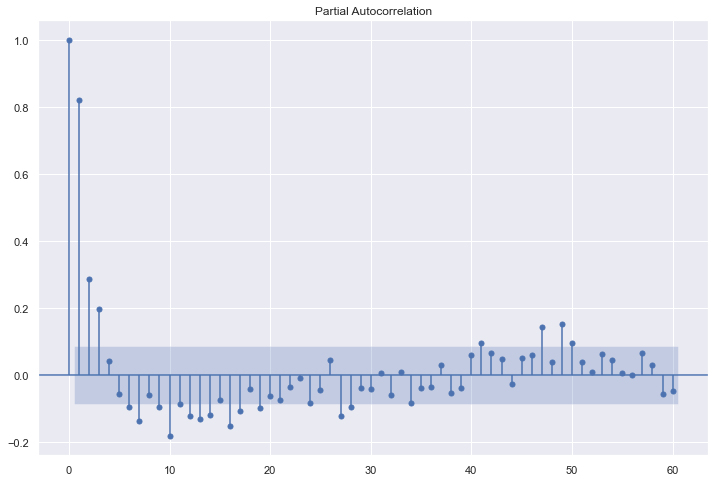

In [54]:
plot_pacf(week_rs,lags=60);

### Recognising processes from ACF and PACF:
- Noise: data points at any given time is completely independent of previous data points. Often, white noise has a normal distribution with mean = 0. Hence, white noise processes will have close to 0 autocorrelation coefficients for all non-zero lags.
- Autoregressive: a given value at time k can be modeled as a linear combination of $k$ previous values preceding k:
\begin{align}
\large{y_{k} = \theta_{k-1}y_{k-1} + \theta_{k-2}y_{k-2} + \theta_{k-3}y_{k-3} + \cdots}
\end{align}
    - The simplest autoregressive process is the AR(1) process (also known as a random walk) composed of only the first lag, $y_{k-1}$, plus a random "shock" $\epsilon(t)$:
\begin{align}
\large{y_k = y_{k-1} + \epsilon(k)}
\end{align}
- Moving average: the current value is a linear combination of the random shocks of past values:
\begin{align}
\large{y_{k} = \mu + \epsilon_{k} + \theta_{k-1}\varepsilon_{k-1} + \theta_{t-2}\varepsilon_{t-2} + \cdots}
\end{align}
    - $\mu$ is the mean of the series. Similarly, the simplest MA process is MA(1) composed:
\begin{align}
\large{y_{k} = \mu + \varepsilon_{k} + \theta\varepsilon_{k-1}}
\end{align}
- Both ACF and PACF should be used to identify AR and MA. Time series often have both elements.
    - AR(p): ACF of AR processes tends to decay slowly to 0, tailing off. PACF cuts off at lag p. Use PACF to tell which order of AR we have.
    - MA(q): ACF cuts off at lag q. PACF tails off. MA processes also tend to have sign osciallating PACF (for orders beyond the confidence level). Use ACF to tell which orders of MA we have.
    - ARMA(p,q): both ACF and PACF tail off.

### Stationarity
- Checking whether the statistical properties of the time series, such as mean or variance, change with time. Stationarity is often a model assumption in time series forecasting. 
- When the time series's variance changes with time, its said to be heteroscedastic.
- To conform with stationarity assumption, a non-stationary time series need to be transformed to being stationary.
- There are two common methods for stationary transformation:
    - Detrending: removing the trend from the time series. This is only applicable for the case for time series where everything else except for the trend is stationary 
    - Differencing: generating a new time series by taking the difference between each timestamp and its preceding value. Differencing has broader application than detrending
        - Another kind of differencing is called seasonal differening where the difference between each value and its seasonally lagged value is calculated

<AxesSubplot:xlabel='date'>

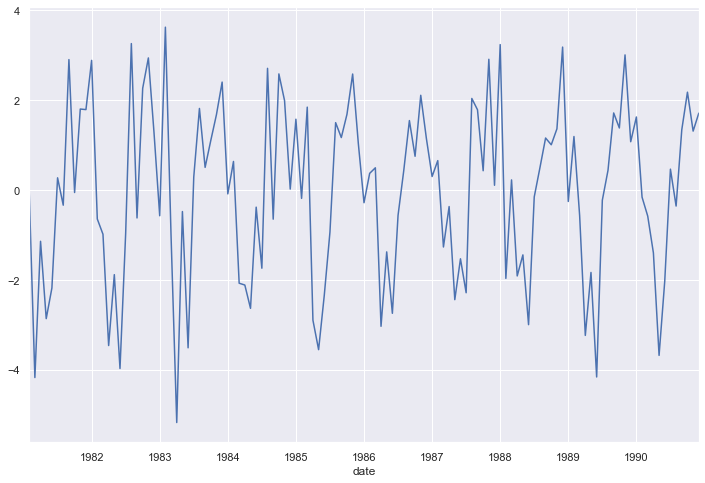

In [55]:
week_rs_diff = month_rs.diff()
week_rs_diff.dropna(inplace=True)
week_rs_diff.plot()

- After the transformation, clearly the time series has become more homoscedastic. However, we can subject this newly created time series for statistical tests to verify the stationarity condition. Note, statistical stationarity tests can only detect certain types of non-stationarity depending on the test in use:
- Dickey-Fuller test:
    - H0: the time series is non-stationary
    - Can only detect trend stationary, i.e., series are stationary except for the trend
- KPSS test:
    - H0: the time series is stationary

In [56]:
def stationarity_test(ts,test="adfuller",nlags="auto",alpha=0.05):
    """
    This function performs user-specified statistical stationarity test and 
    returns a conclusion of whether to accept or reject the null hypothesis within a confidence level"""
    if test == "adfuller":
        result = adfuller(ts) # For fuller test statistic smaller is more significant
        crit_val = result[4]
    elif test == "kpss":
        result = kpss(ts,nlags=nlags) # For kpss test statistic larger is more significant
        crit_val = result[3]
      
    print(f"Results of {test}:")
    print(f'Test statistics: {result[0]}')
    print(f'p-value: {result[1]}')
    print(crit_val)
    if result[1]>alpha:
        if test == "adfuller":
            #H0 = The time series is non-stationary:
            print("Fail to reject H0: the time series is non-stationary")
        else:
            #H0 = The time series is stationary 
            print("Fail to reject H0: the time series is stationary")
    else:
        if test == "adfuller":
            #H0 = The time series is non-stationary:
            print("Reject H0: the time series is stationary")
        else:
            #H0 = The time series is stationary 
            print("Reject H0: the time series is non-stationary")

In [57]:
# Check for stationarity of the original data
stationarity_test(week_rs,test="kpss")
stationarity_test(week_rs)

Results of kpss:
Test statistics: 0.02625055100947372
p-value: 0.1
{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Fail to reject H0: the time series is stationary
Results of adfuller:
Test statistics: -9.273936028363307
p-value: 1.304247156634485e-15
{'1%': -3.4434175660489905, '5%': -2.8673031724657454, '10%': -2.5698395516760275}
Reject H0: the time series is stationary


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Note: Here the original dataset is stationary, so no need for us to include first order difference to set stationarity condition. For completeness, we can run the test on the difference and get the same result. <br>
The p-value for KPSS lies outside of the prescribed range and hence has been resolved to the edge values.

In [58]:
stationarity_test(week_rs_diff,test="kpss")
stationarity_test(week_rs_diff)

Results of kpss:
Test statistics: 0.04644269063420985
p-value: 0.1
{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Fail to reject H0: the time series is stationary
Results of adfuller:
Test statistics: -4.6295763650099335
p-value: 0.00011389116578308279
{'1%': -3.4936021509366793, '5%': -2.8892174239808703, '10%': -2.58153320754717}
Reject H0: the time series is stationary


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Interpretation of stationarity test:
1. The series is not stationary if both tests conclude that the series is not stationary.
2. The series is stationary if both tests conclude that the series is stationary.
3. The series is trend stationary if KPSS indicates stationarity and ADF indicates non-stationarity. Here, trend needs to be removed to make series strict stationary; then the detrended series should be checked again for stationarity.
4. The series is difference stationary if KPSS indicates non-stationarity and ADF indicates stationarity. Here, differencing is to be used to make series stationary; then the differenced series is checked for stationarity.

After the first differencing is performed, successive differencing can be performed until a stationary series is obtained. 

ref https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

##  6. Introduction to modeling using SARIMA
### Basic concepts and parameters
SARIMA stands for <b>S</b>easonal <b>A</b>uto<b>R</b>egressive <b>I</b>ntegrated <b>M</b>oving <b>A</b>verage model. The <b>I</b> here means the model can take into account non-stationary processes by modelling a stationary differenced time series and then integrating the result.

Parameters of SARIMA include $\text{SARIMA}(p,d,q)(P,D,Q)_{m}$:
- $p$ - the order of the non-seasonal autoregressive component: including the peaks outside of the confidence interval in PACF curve
- $d$ - the order of first differencing, determined be counting the number of times the series needs to be differenced to reach stationary. It is unusual to have d>2
- $q$ - the order of the non-seasonal moving average component: determine the peaks outside of the confidence interval in ACF curve
- $P$ - the order of the <i>seasonal</i> autoregressive component: including the peaks outside of the confidence interval in PACF curve appearing at the identified seasonal periodicity 
- $D$ - the order <i>seasonal</i> differencing, counting the number of times the series needs to be seasonal differenced to reach stationary.
- $Q$ - the order of the <i>seasonal</i> moving average component: including the peaks outside of the confidence interval in ACF curve appearing at the identified seasonal periodicity
- $m$ - the number of periods per season. The periodicity of the time series dataset


### Getting train and test data
- The periodicity of the time series has to be preserved as the model is trying to learn behaviour in the past in order to predict the future and there is a natural past-present-future flow in the data

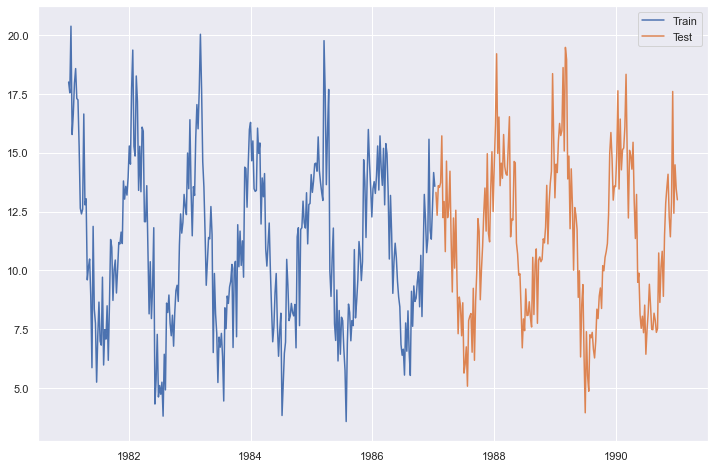

In [60]:
# Try to predict the last 4 years of the dataset
y_train = week_rs.iloc[:-208]
y_test = week_rs.iloc[-208:]

plt.plot(y_train,label='Train')
plt.plot(y_test,label='Test')
plt.legend();

### Model selection and parameter tuning
- Identifying the search space:
    - Examine ACF and PACF for significant lags 
    - Use an iterative approach to include one more lag at a time and examine the ACF and PACF of the residuals plot for further correlations. Stop the iterative approach when the result is reduced to white noise <I>This method is illustrated here</I>.
    - Examine the residual spectral density plot on a log scale. The density is flat if we have achieved reduction to white noise.
- For a good choice of model, the explanatory variables need to be statistically significant, and the residuals to be small relative to the variation in the y values.
- Use selection criteria such as BIC, AIC on the train data (no validation dataset needed, only a train and a test dataset). In this case, we will use AIC - popular amongst choosing time series model. In general, AIC does not only favour models which fit data better but also penalise models with many parameters - helping to avoid overfitting. <I>This method is illustrated here</I>.
- Selection of models can also be based on performance metrics such as R^2, adjusted R^2, MSE, RMSE, although not encouraged, unless it is performed on a separate validation test. However, these performance metrics can be used to measure the performance of the selected model.

#### Initial estimation fot values for p,q,Q and P
- In the case where the series is not stationary, plotting ACF and PACF of the differenced time series can help identify the order of the lags that we need to include in the model. In our case, we can use the original weekly data for this as the time series data is already stationary without differencing
- Note that this should be performed on the train dataset only to retain integrity of the testing data

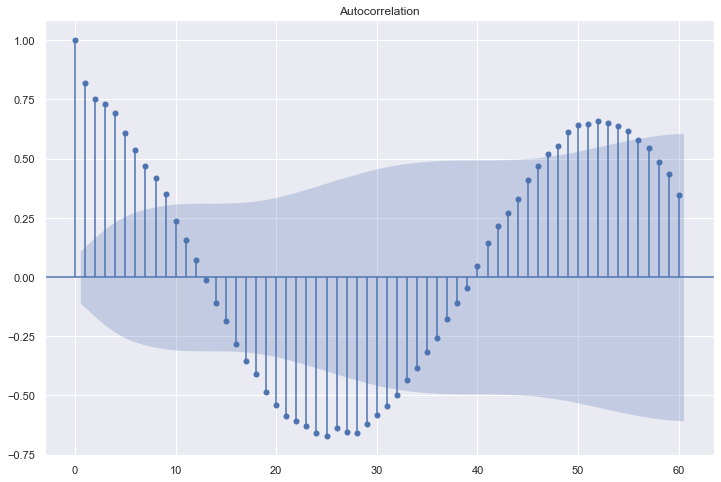

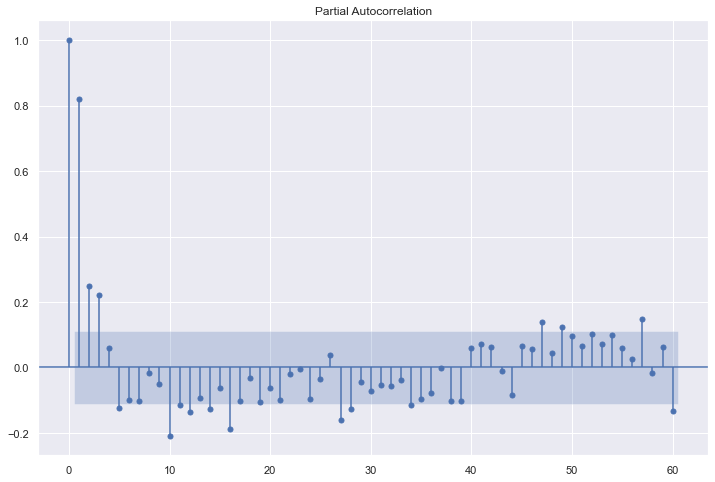

In [121]:
# Finding the value of p and q, Q and P
# y_train_diff = y_train.diff().dropna()
# plot_acf(y_train_diff,lags=60)
# plot_pacf(y_train_diff,lags=60);

plot_acf(y_train,lags=60)
plot_pacf(y_train,lags=60);

Observation:
- Identifying underlying processing:
    - A tailing off ACF and a cut-off PACF signifies a dominantly AR process. Hence we will be using the PACF plot to identify the dominant lags, we will examine the model fit up to AR(3)
- Looking at PACF, largest peaks are seen at [1,2,3]
- Note here the more orders we include in the model, the more likely the model would be overfit
- No differencing required hence d=0
- As identified above period = 52
- At period = 52, we dont see a large peak in PACF

Model interpretation:
- An example of the model can be written as:
\begin{align}
\large{\text{SARIMA}(3, 0, 0)(0, 0, 0)_{52}}
\end{align}
- This means the model is trying to estimate the value at time t by a linear combination of underlying processes (AR and MA) at the identified orders:

\begin{align}
\large{\hat{y}_t} = \theta_{1}\hat{y}_{t-1} + \theta_{2}\hat{y}_{t-2} + \theta_{3}\hat{y}_{t-3} 
\end{align}

#### Residuals diagnostics

Note: <b>X</b> stands for e<b>X</b>ogenous - the implementation of the SARIMA model that can incorporate independent (exogenous) variables. Exogenous variables help predict the endogenous variable (the thing you are trying to forecast), but are not predicted by the model. An example is in predicting non-regular peaks or spikes in a time series where an independent indicator of peaks can be passed on to the model.

In [142]:
def plot_residuals(y_train,p_max_iter=1,q_max=1,d=1,seasonal_order=None,trend="c"):
    """
    This function plots ACF and PACF of the residuals of the model fit
    with different values of p_max
    """
    for i in np.arange(1,p_max_iter+1):
        order = (i,d,q_max)
        model = SARIMAX(y_train, order=order,trend="c",seasonal_order=seasonal_order)
        fitted = model.fit(maxiter=400)
        y_pred = fitted.predict() # Get the fitted values
        
        diff = y_pred.values - y_train.iloc[:,0]
        
        # Plotting ACF and PACF of residuals
        print(f"Residuals ACF and PACF for SARIMA{order}")
        plot_acf(diff,lags=60)
        plot_pacf(diff,lags=60,method='ywm').show();
        plt.show()

Residuals ACF and PACF for SARIMA(1, 0, 0)


<ipython-input-142-f8f646de843a>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_pacf(diff,lags=60,method='ywm').show();


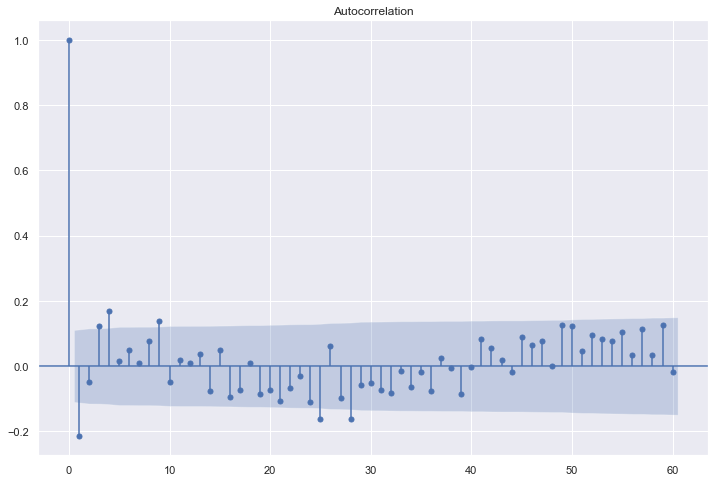

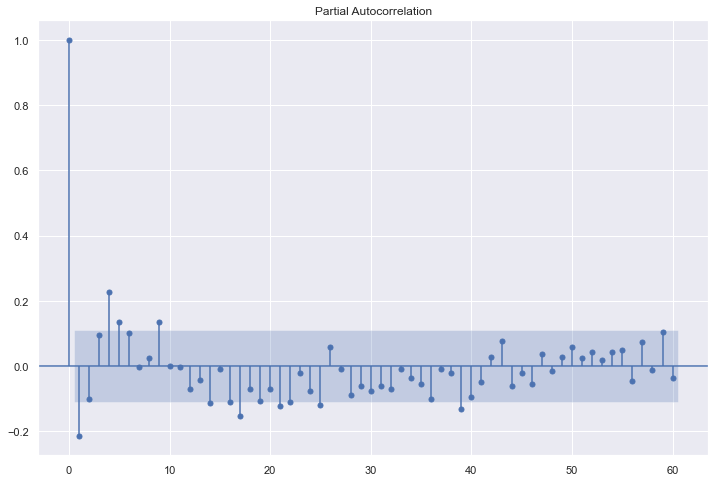

Residuals ACF and PACF for SARIMA(2, 0, 0)


<ipython-input-142-f8f646de843a>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_pacf(diff,lags=60,method='ywm').show();


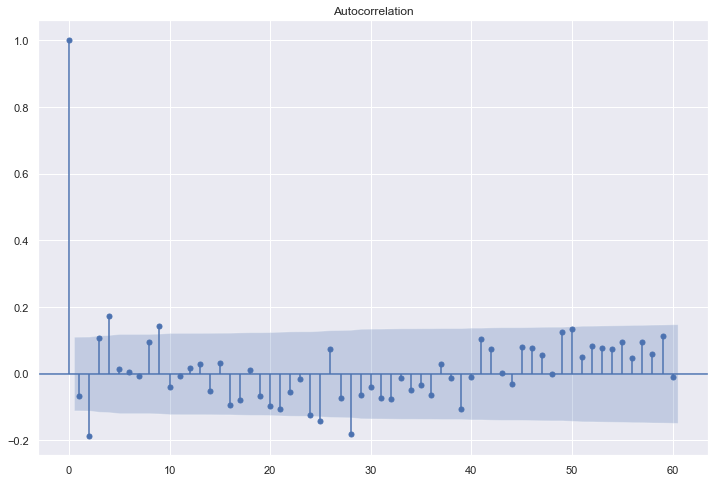

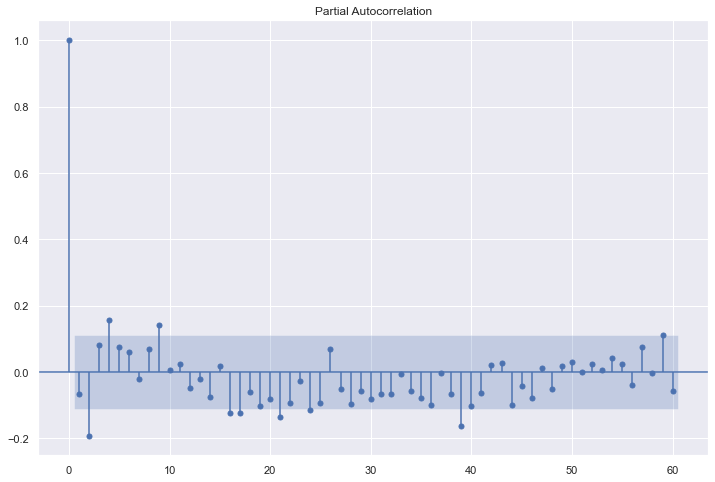

Residuals ACF and PACF for SARIMA(3, 0, 0)


<ipython-input-142-f8f646de843a>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_pacf(diff,lags=60,method='ywm').show();


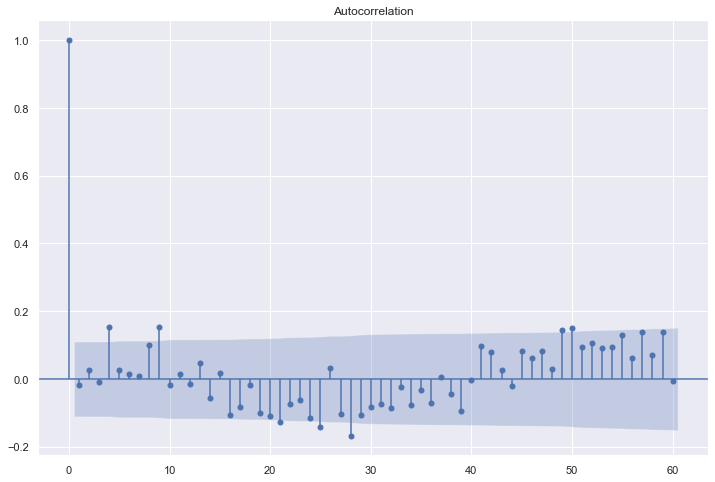

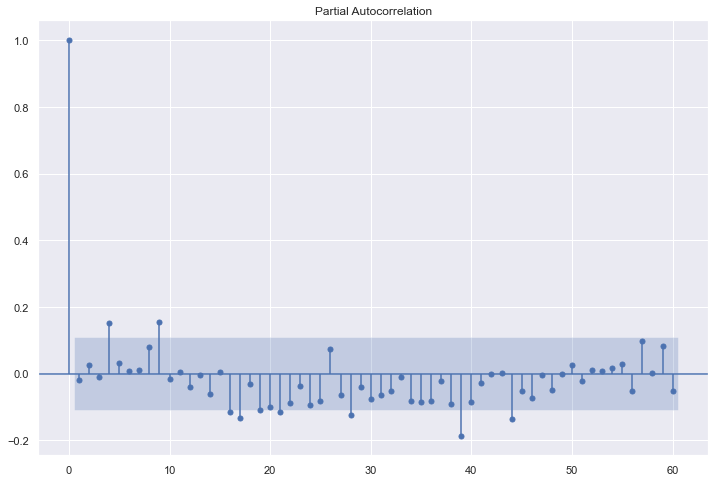

In [143]:
plot_residuals(y_train,p_max_iter=3,q_max=0,d=0,seasonal_order=(0,0,0,52))

Note: after AR(2) no significant peaks are observed. Hence, we can try the parameter space up to AR(2)

#### Gridsearch for selected parameter space

In [103]:
def mean_squared_error(y_pred,y_actual):
    return ((y_pred-y_actual)**2).mean()

In [144]:
def SarimaGridSearch(ts,p_max=1,d_max=1,q_max=1,P_max=1,D_max=1,Q_max=1,m=52,trend=None):
    """
    This function generates a search space of 7 key parameters for SARIMA algorithm and 
    systematically runs through each combination. The function compare the model performance 
    using AIC and returns the best performing combination
    """
    
    # Define range of parameters of interest
    p = range(p_max+1)
    d = range(d_max+1)
    q = range(q_max+1)
    P = range(P_max+1)
    D = range(D_max+1)
    Q = range(Q_max+1)

    # Create a list of all possible combinations of order parameters defined by the range above
    orders = list(itertools.product(p, d, q))

    # Create a list of all different combinations of seasonal p, q and q values
    seasonal_orders = [(val[0], val[1], val[2], m) for val in list(itertools.product(P, D, Q))]
    seasonal_orders.append(None) # Add in none seasonability option

    # lower AIC means better model, so initialize best AIC to infinity
    best_AIC = np.inf
    best_order = None
    best_seasonal_order = None
    
    # train SARIMA model for each combination of seasonal and non-seasonal parameters
    for order in orders: # iterate through all options of orders
        for seasonal_order in seasonal_orders: # iterate through all options of seasonal_orders

            model = SARIMAX(ts,
                          order=order,
                          seasonal_order=seasonal_order,
                          enforce_stationarity=False,
                          enforce_invertibility=False,trend=trend)

            fitted = model.fit(maxiter=150) # maximum iteration can be added here, e.g.,maxiter=200

            # Print results
            print('SARIMA{}x{} - AIC:{}'.format(order,seasonal_order,fitted.aic))
            
            # if current model has lower AIC than current best value, update bestAIC
            if fitted.aic < best_AIC:
                best_AIC = fitted.aic
                best_order = order
                best_seasonal_order = seasonal_order
                best_fitted = fitted
                
    print('Best AIC:',best_AIC)
    print('Best non-seasonal order:',best_order)
    print('Best seasonal order:',best_seasonal_order)
    
    return best_order,best_seasonal_order,best_fitted

In [145]:
order,seasonal_order,model = SarimaGridSearch(y_train,p_max=2,m=52,trend="c")

SARIMA(0, 0, 0)x(0, 0, 0, 52) - AIC:1678.0148546206296
SARIMA(0, 0, 0)x(0, 0, 1, 52) - AIC:1293.9670612492182
SARIMA(0, 0, 0)x(0, 1, 0, 52) - AIC:1194.8003818781633
SARIMA(0, 0, 0)x(0, 1, 1, 52) - AIC:885.3054577650591
SARIMA(0, 0, 0)x(1, 0, 0, 52) - AIC:1156.0167403431426
SARIMA(0, 0, 0)x(1, 0, 1, 52) - AIC:1088.6911271114432
SARIMA(0, 0, 0)x(1, 1, 0, 52) - AIC:910.8676035986923
SARIMA(0, 0, 0)x(1, 1, 1, 52) - AIC:895.4899305987425
SARIMA(0, 0, 0)xNone - AIC:1678.0148546206296
SARIMA(0, 0, 1)x(0, 0, 0, 52) - AIC:1490.726634970732
SARIMA(0, 0, 1)x(0, 0, 1, 52) - AIC:1185.977292148379
SARIMA(0, 0, 1)x(0, 1, 0, 52) - AIC:1174.2629779756744
SARIMA(0, 0, 1)x(0, 1, 1, 52) - AIC:867.2790044533072
SARIMA(0, 0, 1)x(1, 0, 0, 52) - AIC:1126.5197905442187
SARIMA(0, 0, 1)x(1, 0, 1, 52) - AIC:1070.4246707988063
SARIMA(0, 0, 1)x(1, 1, 0, 52) - AIC:898.2784864898636
SARIMA(0, 0, 1)x(1, 1, 1, 52) - AIC:879.4574747288493
SARIMA(0, 0, 1)xNone - AIC:1490.726634970732
SARIMA(0, 1, 0)x(0, 0, 0, 52) - AIC:1

#### Best model's result visualisation and prediction

In [146]:
# Forcasting using the best performing model based on AIC
y_pred = model.get_forecast(len(y_test))
y_pred_mean = y_pred.predicted_mean
y_pred_mean.head()
# Finding MSE
mse = mean_squared_error(y_pred_mean.values,y_test.iloc[:,0])
print(f'Root mean squared error: {np.sqrt(mse):.2f}')

Root mean squared error: 1.74


                                     SARIMAX Results                                      
Dep. Variable:                               temp   No. Observations:                  315
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood                -425.553
Date:                            Tue, 22 Mar 2022   AIC                            861.106
Time:                                    13:55:15   BIC                            877.794
Sample:                                01-04-1981   HQIC                           867.854
                                     - 01-11-1987                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0014      0.002      0.877      0.381      -0.002       0.004
ar.L1          0.2700      0.062   

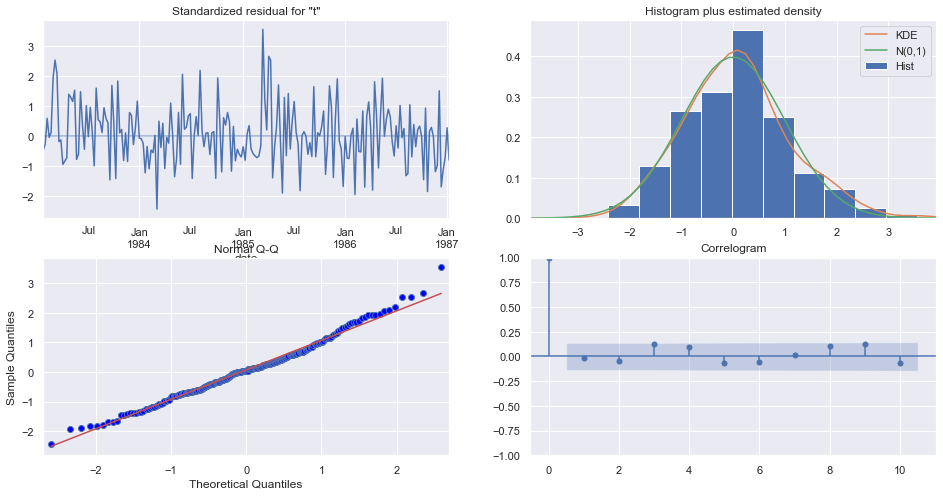

In [147]:
# Showing summary results
print(model.summary()) #.tables[1]
model.plot_diagnostics(figsize=(16, 8))
plt.show()

Note: Residuals are normally distributed with a root mean squared error of 1.74

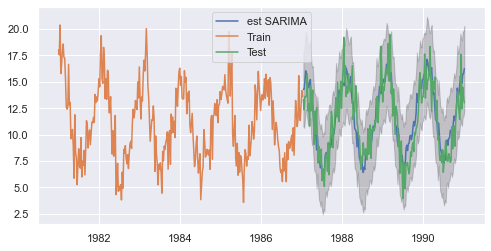

In [148]:
# Visualisation of results with confidence level
conf_int = y_pred.conf_int()
plt.figure(figsize=(8,4))
plt.plot(y_pred_mean,label='est SARIMA')
plt.plot(y_train,label='Train')
plt.plot(y_test,label='Test')
plt.fill_between(conf_int.index,
                conf_int.iloc[:, 0],
                conf_int.iloc[:, 1], color='k', alpha=.2)
plt.legend()
plt.show();

###### Conclusion:
- SARIMA analysis gives pretty good prediction with a root mean square of 1.74. 
- Additional analysis including exogeneous variables or seasonal differencing can be considered